[Source](https://github.com/giakoumoglou/classification/blob/main/notebooks/main_simclr.ipynb)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm


from src_supcon import TwoCropTransform, SupConLoss, supcon_train, supcon_train_step

In [20]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device=='cuda':
    print(torch.cuda.get_device_properties(0).name)


LOAD_MODELS = True

cpu


# DATA

In [21]:

contrastive_transform = transforms.Compose([
                                transforms.RandomResizedCrop(size=(28, 28), scale = (0.5, 0.95)),
                                transforms.RandomRotation(degrees=45),
                                transforms.ToTensor(),
                                    ])




class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform = contrastive_transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x), transforms.ToTensor()(x)]


In [22]:
batch_size = 64

dataset = datasets.MNIST('./data', download=True, train=True, transform=TwoCropTransform())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [23]:

batch, label = next(iter(dataloader))

fig, axs = plt.subplots(8, 3, figsize=(3, 8))

for i in range(8):
    orig = batch[2][i][0]
    view_1 = batch[0][i][0]
    view_2 = batch[1][i][0]

    axs[i, 0].imshow(orig.numpy(), cmap='gray')
    if i==0:
        axs[i, 0].set_title('Original')
    axs[i, 0].axis('off')

    for j, view in enumerate([view_1, view_2], 1):
        
        axs[i, j].imshow(view.numpy(), cmap='gray')
        axs[i, j].axis('off')
        if i==0:
            axs[i, j].set_title('View {}'.format(j))

#remove space between subplots
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()





# LOSS AND MODEL

In [24]:

class SupConLoss(nn.Module): #TODO check/test this loss
    #src: https://github.com/giakoumoglou/classification/tree/main/notebooks
    #if no labels are provided, it is basically the SimCLRLoss #TODO check this with SimCLRLoss class
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07,
                 device = 'cpu'):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

        self.device = device

    def forward(self, features, labels=None, mask=None):

        device = self.device

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss


In [25]:
class Encoder(nn.Module):

    "Encoder network"
    def __init__(self):
        super(Encoder, self).__init__()
    
        image_channels = 1
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 16, kernel_size=2, stride=2),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten()
        )

    def forward(self, x):
        return self.encoder(x)
    
class ProjectionHead(nn.Module):
    "Projection head"
    def __init__(self, input_dim=288, hidden_dim=128, output_dim=64):
        super(ProjectionHead, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.projection_head(x)
    

class SupCon(nn.Module):
    """encoder + projection head"""
    def __init__(self, encoder, head):
        super(SupCon, self).__init__()
        self.encoder = encoder
        self.head = head

    def forward(self, x):
        x = self.encoder(x)
        x = F.normalize(self.head(x), dim=1)
        return x


In [26]:



encoder = Encoder().to(device)
head = ProjectionHead().to(device)
model = SupCon(encoder=encoder, head = head).to(device)



criterion = SupConLoss(temperature=temperature, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)



# TRAINING LOOP

In [27]:

def supcon_train_step(epoch, 
                model, criterion, optimizer, 
                scheduler,
                dataloader_train, 
                history=None, device = 'cpu'):
    
    model.train()

    running_loss = 0.0
    for data, target in dataloader_train:
        batch_size = data[0].shape[0]
        data = torch.cat([data[0], data[1]], dim=0)
        data = data.to(device)

        features = model(data)

        f1, f2 = torch.split(features, [batch_size, batch_size], dim=0)
        features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)

        loss = criterion(features)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step() if scheduler is not None else None

        running_loss += loss.item()
    
    running_loss = running_loss/len(dataloader_train)

    print('Epoch: {} Loss: {:.5f}'.format(epoch, running_loss))

    if history is not None:
        history['train_loss'].append(running_loss)
    
    return running_loss


def supcon_train(epochs,
                model, criterion, optimizer, 
                scheduler,
                dataloader_train, 
                history=None, device = 'cpu'):
    

    pbar_epoch = tqdm(range(epochs), desc='Epochs')

    history = {'train_loss': [], 'val_loss': []}

    try:
        for epoch in pbar_epoch:
            loss = supcon_train_step(epoch, 
                                    model, criterion, optimizer, 
                                    scheduler,
                                    dataloader_train, 
                                    history, device)
            pbar_epoch.set_postfix({'loss': loss})
    except KeyboardInterrupt:
        print('Interrupted')


    return history


# TRAIN

In [28]:
n_epochs = 4

history = supcon_train(n_epochs, 
                       model, criterion, optimizer, scheduler=scheduler,
                           dataloader_train=dataloader,
                           device=device)


Epochs:  25%|██▌       | 1/4 [00:42<02:06, 42.22s/it, loss=3.82]

Epoch: 0 Loss: 3.81773


Epochs:  50%|█████     | 2/4 [01:24<01:24, 42.03s/it, loss=3.8] 

Epoch: 1 Loss: 3.80031


Epochs:  75%|███████▌  | 3/4 [02:06<00:42, 42.13s/it, loss=3.8]

Epoch: 2 Loss: 3.79527


Epochs: 100%|██████████| 4/4 [02:50<00:00, 42.73s/it, loss=3.8]

Epoch: 3 Loss: 3.79647


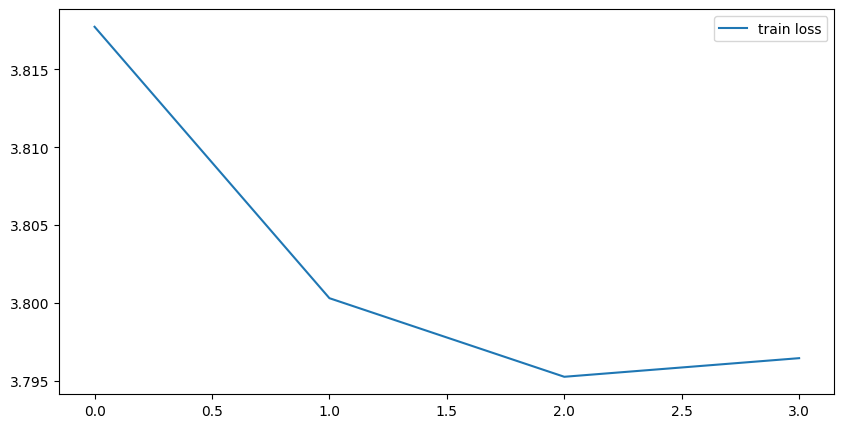

In [31]:
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='train loss')
plt.legend()

-----

# 4. Main

In [ ]:
import os
def main():

    num_epochs = 5
    use_scheduler = True
    save_file = os.path.join('./models/', 'simclr.pth')
    if not os.path.isdir('./results/'):
         os.makedirs('./results/')

    contrastive_transform = transforms.Compose([
                                    transforms.RandomResizedCrop(size=(28, 28), scale = (0.5, 0.95)),
                                    transforms.RandomRotation(degrees=45),
                                    transforms.ToTensor(),
                                       ])
    

    train_transform = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])
    valid_transform = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])
    

    contrastive_set = datasets.MNIST('./data', download=True, train=True, transform=TwoCropTransform(contrastive_transform))

    contrastive_loader = torch.utils.data.DataLoader(contrastive_set, batch_size=64, shuffle=True)

    # Part 1
    encoder = Encoder()
    head = ProjectionHead()
    model = SupCon(encoder, head)

    criterion = SupConLoss(temperature=0.07)
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

    contrastive_loss, contrastive_lr = [], []

    for epoch in range(1, num_epochs+1):
        print('Epoch:', epoch, '/', num_epochs)
        loss  = pretraining(epoch, model, contrastive_loader, optimizer, criterion)
        if use_scheduler:
            scheduler.step()
        contrastive_loss.append(loss)
        print('-->Loss', loss)


    plt.plot(range(1,len(contrastive_loss)+1),contrastive_loss, color='b', label = 'loss')
    plt.legend(), plt.ylabel('loss'), plt.xlabel('epochs'), plt.title('Loss'), plt.show()
    plt.xlabel('epochs'), plt.title('Accuracy'), plt.show()

In [ ]:
%matplotlib inline
main()